# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

import warnings
warnings.filterwarnings('ignore')

In [2]:
def display_img(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters <a name="parameters"></a>

In [20]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 32
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 15
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [22]:
# Load the data
#грузим изображения и сжимаем их до 32х32 с помощью интерполяции пикселов
#данные в память будут грузится только при необходимости, например, во время обучения
train_data = utils.image_dataset_from_directory(
    "data/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [23]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))

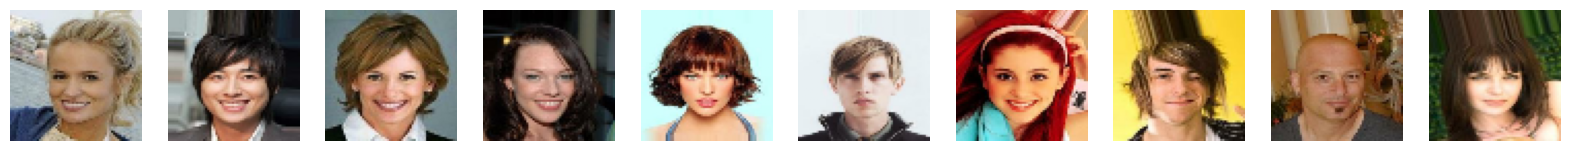

In [17]:
#берет батч примеров
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

train_sample = sample_batch(train)

# Show some faces from the training set
display_img(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)          0         ['batch_normalization[

In [9]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                    

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [24]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [25]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# Load old weights if required
# if LOAD_MODEL:
#     vae.load_weights("./models/vae")
#     tmp = vae.predict(train.take(1))

In [26]:
vae.fit(
    train,
    epochs=EPOCHS)
#     ,callbacks=[
#         model_checkpoint_callback,
#         tensorboard_callback,
#         ImageGenerator(num_img=10, latent_dim=Z_DIM),
#     ],
# )
#батч 200 - 30-33

Epoch 1/15


6332/6332 [==============================] - 2056s 324ms/step - loss: 71.3522 - reconstruction_loss: 52.3924 - kl_loss: 17.6977
Epoch 2/15
6332/6332 [==============================] - 1915s 302ms/step - loss: 68.0750 - reconstruction_loss: 50.0718 - kl_loss: 17.6504
Epoch 3/15
6332/6332 [==============================] - 2037s 322ms/step - loss: 67.0939 - reconstruction_loss: 49.2136 - kl_loss: 17.6555
Epoch 4/15
6332/6332 [==============================] - 2126s 336ms/step - loss: 66.4434 - reconstruction_loss: 48.6353 - kl_loss: 17.6500
Epoch 5/15
6332/6332 [==============================] - 2142s 338ms/step - loss: 65.9788 - reconstruction_loss: 48.1553 - kl_loss: 17.7172
Epoch 6/15
6332/6332 [==============================] - 2122s 335ms/step - loss: 65.7207 - reconstruction_loss: 47.8541 - kl_loss: 17.7503
Epoch 7/15
6332/6332 [==============================] - 2173s 343ms/step - loss: 65.4998 - reconstruction_loss: 47.6214 - kl_loss: 17.7857
Epoch 8/15
6332/6332 [================

In [27]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [28]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

1/1 [==============================] - 0s 400ms/step
Example real faces


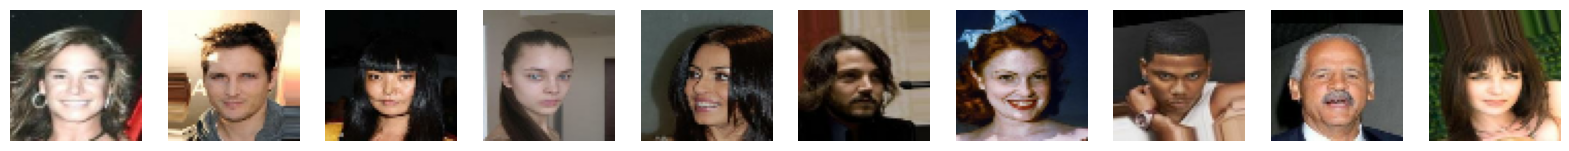

Reconstructions


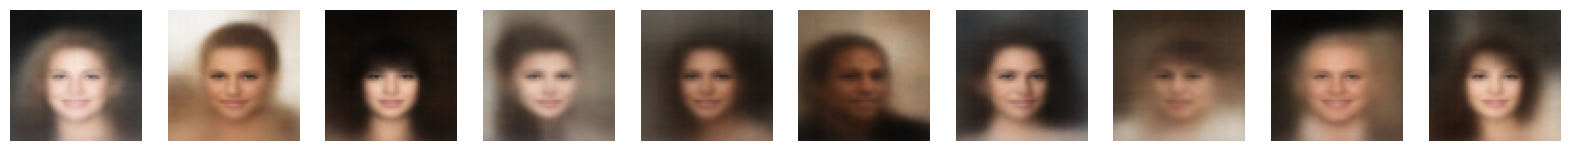

In [29]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display_img(example_images)
print("Reconstructions")
display_img(reconstructions)

## 4. Latent space distribution

1/1 [==============================] - 0s 142ms/step


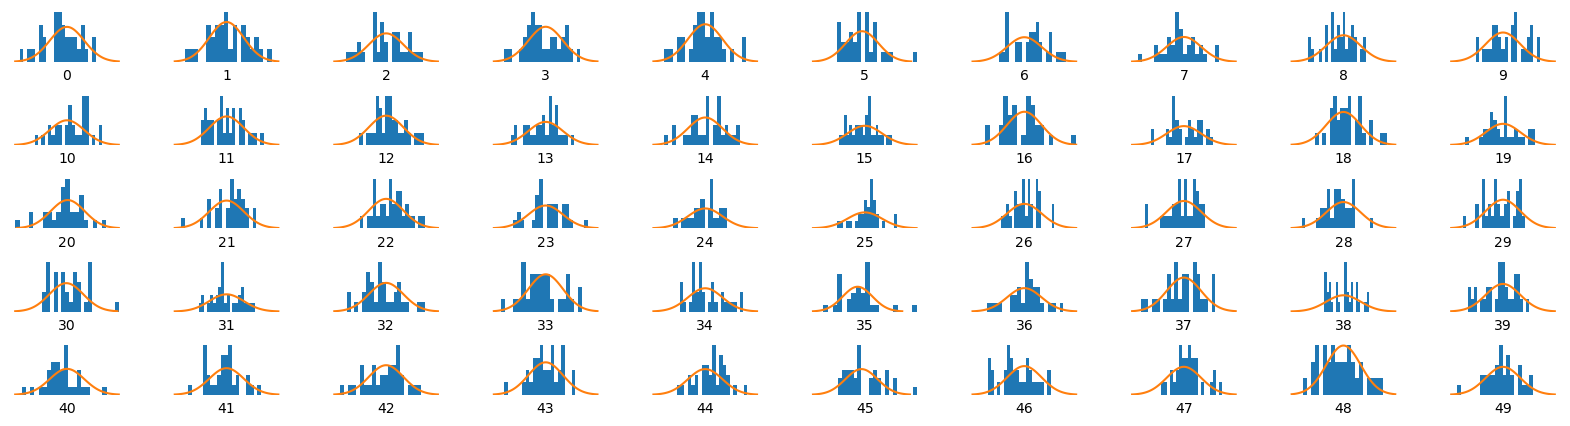

In [30]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [31]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [32]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 261ms/step


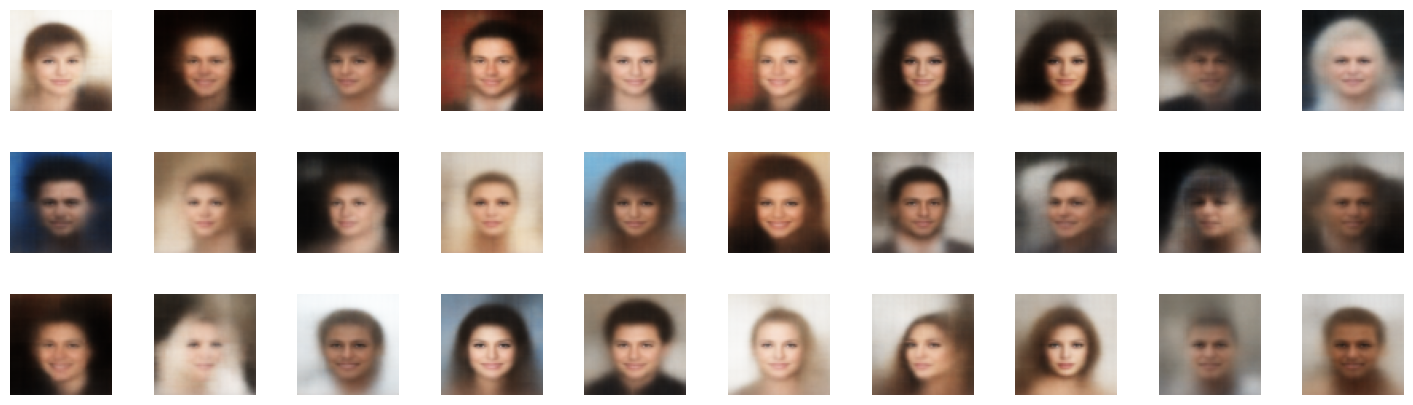

In [33]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [34]:
# Load the label dataset
attributes = pd.read_csv("data/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [35]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "data/img_align_celeba/img_align_celeba/",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [36]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
3    : 8.066    : 2.424    : 8.571    : 8.571
4    : 3.823    : 1.873    : 6.955    : -1.617
10    : 5.255    : 0.994    : 4.588    : -2.367
13    : 2.143    : 0.768    : 4.108    : -0.48
16    : 1.548    : 0.606    : 3.976    : -0.132
24    : 1.83    : 0.463    : 3.377    : -0.599
30    : 1.264    : 0.404    : 3.082    : -0.295
36    : 1.055    : 0.346    : 2.961    : -0.12
38    : 0.512    : 0.31    : 2.905    : -0.057
41    : 0.587    : 0.307    : 2.808    : -0.097
45    : 0.627    : 0.256    : 2.73    : -0.078
50    : 0.653    : 0.239    : 2.611    : -0.119
56    : 0.643    : 0.216    : 2.502    : -0.11
64    : 0.678    : 0.185    : 2.418    : -0.083
68    : 0.464    : 0.207    : 2.385    : -0.033
74    : 0.496    : 0.175    : 2.272    : -0.113
76    : 0.252    : 0.169    : 2.255    : -0.017
82    : 0.463    : 0.15    : 2.203    : -0.052
87    : 0.357    : 0.12    : 2.128    : -0.076
92    : 0.349    : 0.139    :

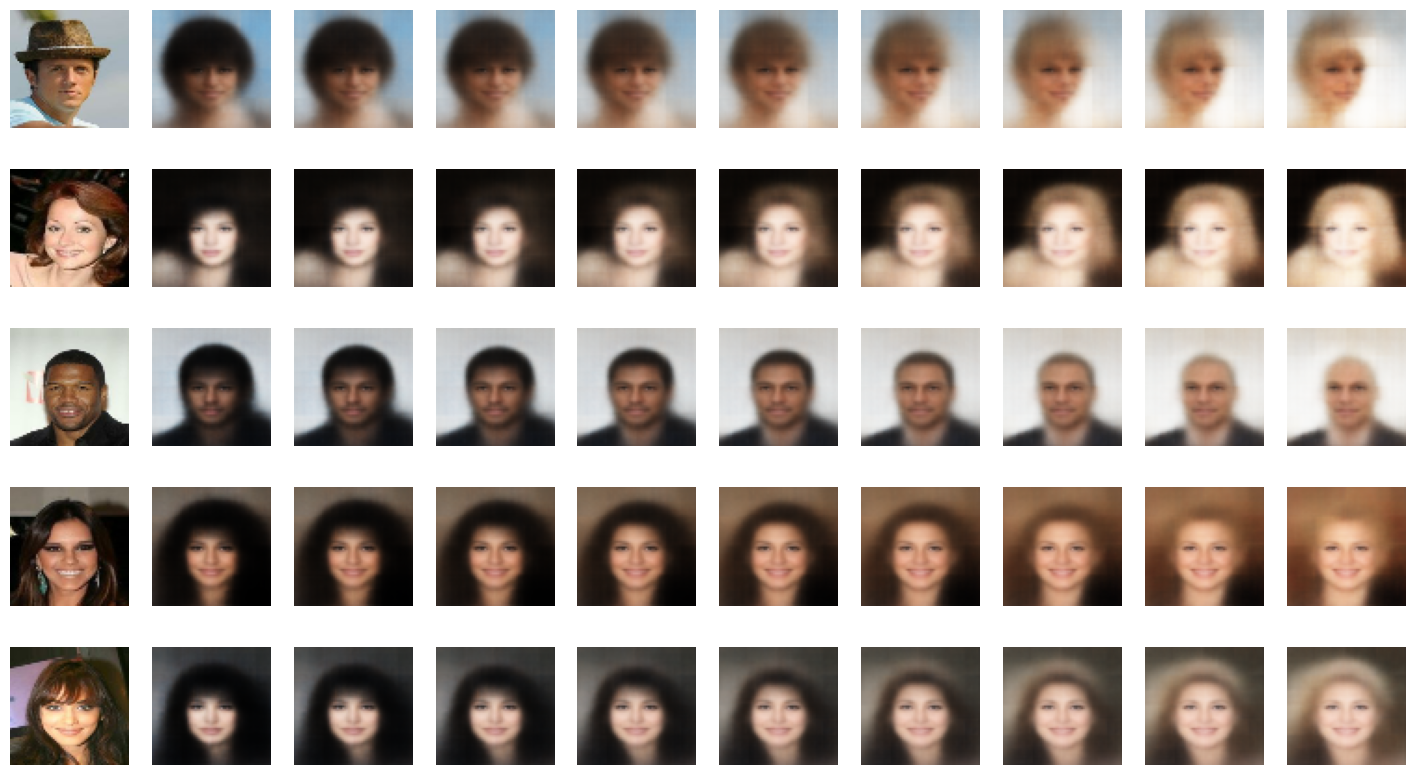

In [37]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

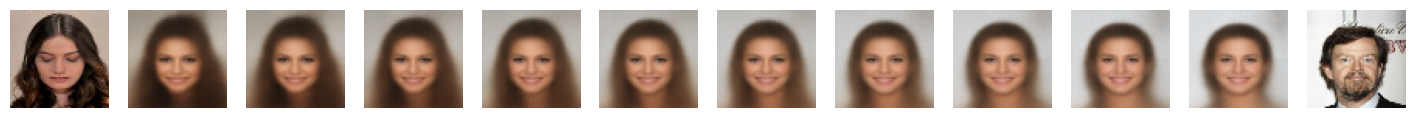

In [38]:
morph_faces(labelled, vae)